# 2022 FIFA World Cup prediction modeling

---

### by Mateusz Baczewski & Aleksander Mszyca

Method based on multinomial logistic regression, with use of self-calculated teams' ELO ranking score as a predictor.

---

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
from collections import Counter
warnings.filterwarnings('ignore')

---

## Read data

In [2]:
data = pd.read_csv("results.csv")
data.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False


In [3]:
data = data.dropna()

In [4]:
print(f"Number of rows: {data.shape[0]}")

Number of rows: 44059


In [5]:
teams = set(data['home_team']) | set(data['away_team'])
print(f"Number of teams in the dataset: {len(teams)}")

Number of teams in the dataset: 316


---

## Create calculated columns

### Goal difference

In [6]:
data['goal_diff'] = abs(data.home_score - data.away_score)

### Year

In [7]:
data['year'] = data.date.astype('str').apply(lambda x: int(x[:4]))

### Coded result variable

In [8]:
def result(a, b):
    
    if a == b:
        return 0.5
    
    elif a > b:
        return 1
    
    elif a < b:
        return 0
    
for n in range(data.shape[0]):
    data.loc[n, 'result'] = result(data.home_score[n], data.away_score[n])

In [9]:
data.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,goal_diff,year,result
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,0.0,1872,0.5
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,2.0,1873,1.0
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,1.0,1874,1.0
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,0.0,1875,0.5
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,3.0,1876,1.0


---

## Calculating ELO scores

### Define multipliers used to calculate ELO scores

In [10]:
def return_multiplier(tournament_type):
    
    tournament_type = tournament_type.upper()
    
    world = ['FIFA World Cup qualification', 'UEFA Euro qualification', 
             'AFC Asian Cup qualification', 'African Cup of Nations qualification', 
             'Gold Cup qualification', 'Copa América qualification', 
             'Oceania Nations Cup qualification']
    world = [i.upper() for i in world]
    
    nations_cups = ['AFC ASIAN CUP', 'Gold Cup', 'Copa América', 'Oceania Nations Cup', 'African Cup of Nations', 'UEFA Euro']    
    nations_cups = [i.upper() for i in nations_cups]
    
    group_30 = ['UEFA Nations League', 'African Nations Championship', 'CONCACAF Nations League']
    group_30 = [i.upper() for i in group_30]
    
    if tournament_type == 'FIFA WORLD CUP':
        return 60
        
    elif tournament_type in nations_cups:
        return 50
        
    elif tournament_type in world:
        return 40
        
    elif tournament_type in group_30:
        return 30
    
    else:
        return 20
    

In [11]:
def return_goal_multiplier(goal_difference):
    
    if goal_difference == 2:
        return 1.5
    
    elif goal_difference == 3:
        return 1.75
    
    elif goal_difference >= 4:
        return (0.75 + (goal_difference - 3)/8)
    
    else:
        return 1
    

### Create function that returns the ELO score

In [12]:
def score(points_of_home_team, points_of_away_team, result_from_perspective_of_ht, tournament_type, goal_diff):
    
    tournament_multiplier = return_multiplier(tournament_type)
    goal_multiplier = return_goal_multiplier(goal_diff)
    multiplier = tournament_multiplier * goal_multiplier
    
    expected_for_x = 1 / (10**(-(points_of_home_team - points_of_away_team)/400) + 1)
    expected_for_y = 1 / (10**(-(points_of_away_team - points_of_home_team)/400) + 1)
    
    change_x = multiplier * (result_from_perspective_of_ht - expected_for_x)
    change_y = multiplier * ((1 - result_from_perspective_of_ht) - expected_for_y)
    
    return points_of_home_team + change_x, points_of_away_team + change_y, expected_for_x, expected_for_y


### Implement ELO ranking in the dataset

In [13]:
score_dict = dict()

for team in teams:
    score_dict[team] = 1500

for n in range(data.shape[0]):
    data.loc[n, 'home_team_elo_before'] = score_dict[data.loc[n, 'home_team']]
    data.loc[n, 'away_team_elo_before'] = score_dict[data.loc[n, 'away_team']]
    
    homes_points, away_points, calculated_prob_home, calculated_prob_away = score(data.loc[n, 'home_team_elo_before'], data.loc[n, 'away_team_elo_before'], data.loc[n, 'result'], data.loc[n, 'tournament'], data.loc[n, 'goal_diff'])
    
    data.loc[n, 'home_team_elo_after'] = homes_points
    data.loc[n,'away_team_elo_after'] = away_points
    
    score_dict[data.loc[n, 'home_team']]= homes_points
    score_dict[data.loc[n, 'away_team']] = away_points
    
    data.loc[n,'calculated_home_win_prob'] = calculated_prob_home
    data.loc[n,'calculated_away_win_prob'] = calculated_prob_away
    

### Current ELO ranking

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    df = pd.DataFrame.from_dict(score_dict, orient = "index").sort_values(0, ascending = False)
    df['Position'] = range(1, len(df) + 1)
    df.columns = ['ELO Score', 'Position']
    print(df)

                                    ELO Score  Position
Brazil                            2154.211982         1
Argentina                         2112.967397         2
Belgium                           2034.844380         3
Spain                             2025.615129         4
Netherlands                       2019.058357         5
Italy                             2001.974399         6
France                            1996.275743         7
England                           1983.093316         8
Portugal                          1974.411935         9
Germany                           1964.970772        10
Denmark                           1947.070760        11
Switzerland                       1937.365009        12
Uruguay                           1928.308774        13
Colombia                          1921.226037        14
Croatia                           1902.742927        15
South Korea                       1893.255846        16
Japan                             1890.809753   

### Data with ELO implemented

In [15]:
data.tail(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,goal_diff,year,result,home_team_elo_before,away_team_elo_before,home_team_elo_after,away_team_elo_after,calculated_home_win_prob,calculated_away_win_prob
44054,2022-09-27,Albania,Iceland,1.0,1.0,UEFA Nations League,Tirana,Albania,False,0.0,2022,0.5,1576.691349,1597.712278,1577.597790,1596.805837,0.469785,0.530215
44055,2022-09-27,Norway,Serbia,0.0,2.0,UEFA Nations League,Oslo,Norway,False,2.0,2022,0.0,1749.988486,1853.098055,1733.976516,1869.110025,0.355822,0.644178
44056,2022-09-27,Sweden,Slovenia,1.0,1.0,UEFA Nations League,Stockholm,Sweden,False,0.0,2022,0.5,1754.052523,1640.558209,1749.319737,1645.290995,0.657760,0.342240
44057,2022-09-27,Kosovo,Cyprus,5.0,1.0,UEFA Nations League,Pristina,Kosovo,False,4.0,2022,1.0,1537.519066,1407.180698,1545.938978,1398.760786,0.679241,0.320759
44058,2022-09-27,Greece,Northern Ireland,3.0,1.0,UEFA Nations League,Athens,Greece,False,2.0,2022,1.0,1698.928897,1606.037352,1715.552578,1589.413671,0.630585,0.369415


---

## Dataset analysis

### Calculated home team win probabilities vs real match results

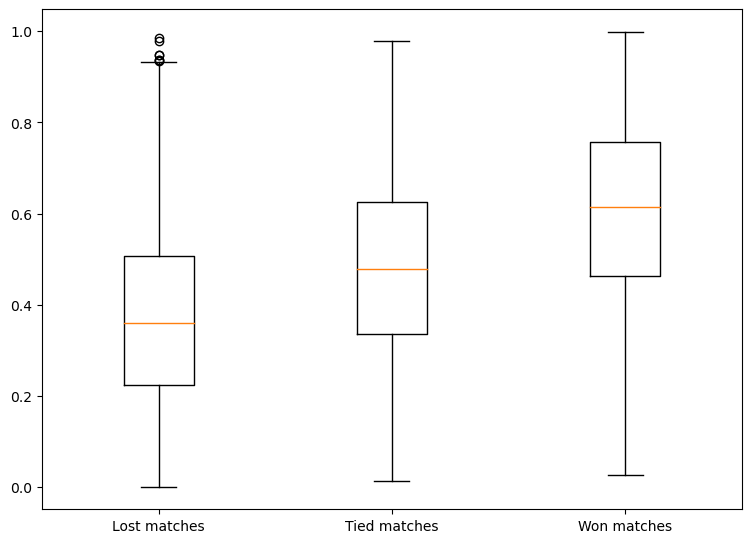

In [16]:
data_loose = data.calculated_home_win_prob[data.result == 0]
data_draw = data.calculated_home_win_prob[data.result == 0.5]
data_win = data.calculated_home_win_prob[data.result == 1]

to_plot = [data_loose, data_draw, data_win]
 
fig = plt.figure(figsize = (7, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(['Lost matches', 'Tied matches', 'Won matches'])
bp = ax.boxplot(to_plot)

### Calculated teams' ELO scores vs real match results

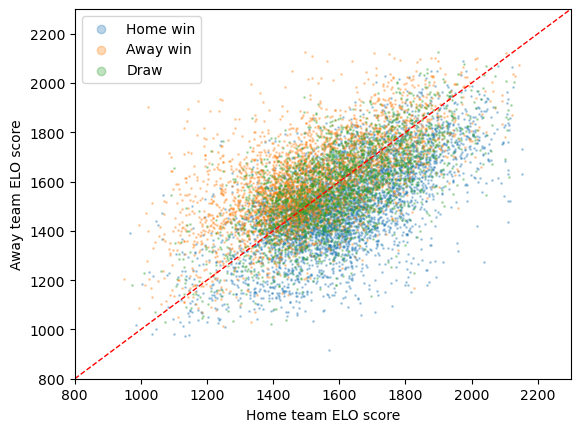

In [17]:
plt.scatter(data.home_team_elo_before[(data.result==1) & (data.neutral==True)], data.away_team_elo_before[(data.result==1) & (data.neutral==True)], s=1, alpha = 0.3)
plt.scatter(data.home_team_elo_before[(data.result==0) & (data.neutral==True)], data.away_team_elo_before[(data.result==0) & (data.neutral==True)], s=1, alpha = 0.3)
plt.scatter(data.home_team_elo_before[(data.result==0.5) & (data.neutral==True)], data.away_team_elo_before[(data.result==0.5) & (data.neutral==True)], s=1, alpha = 0.3)
plt.axline((0, 0), slope = 1, linestyle = '--',linewidth = 1, color = "red")
plt.xlim([800, 2300])
plt.ylim([800, 2300])
plt.ylabel("Away team ELO score")
plt.xlabel("Home team ELO score")
plt.legend(['Home win', 'Away win', 'Draw'], markerscale = 6)

---

## Pre-modeling data preparation

### Cleaning not internationally recognized teams

In [18]:
to_delete = ['Abkhazia', 'Åland Islands', 'Alderney', 'Andalusia', 'Arameans Suryoye', 'Artsakh', 'Asturias', 'Aymara',
             'Barawa', 'Basque Country', 'Biafra', 'Brittany', 'Canary Islands', 'Cascadia', 'Catalonia', 'Central Spain',
            'Bonaire', 'Chagos Islands', 'Chameria', 'Corsica', 'County of Nice', 'Crimea', 'Darfur', 'Ellan Vannin',
            'Falkland Islands', 'Felvidék', 'French Guiana', 'Frøya', 'Găgăuzia', 'Galicia', 'Gotland', 'Gozo', 'Greenland',
            'Guadeloupe', 'Guernsey', 'Hitra', 'Iraqi Kurdistan', 'Isle of Man', 'Isle of Wight', 'Jersey', 'Kabylia',
            'Kárpátalja', 'Kernow', 'Macau', 'Madrid', 'Manchukuo', 'Mapuche', 'Matabeleland', 'Maule Sur', 'Mayotte',
            'Menorca', 'Niue', 'Northern Cyprus', 'Northern Mariana Islands', 'Occitania', 'Orkney', 'Padania', 'Palestine',
            'Panjab', 'Parishes of Jersey', 'Provence', 'Raetia', 'Republic of St. Pauli', 'Réunion', 'Rhodes', 'Romani people',
            'Saare County', 'Saarland', 'Saint Helena', 'Saint Martin', 'Saint Pierre and Miquelon', 'Sápmi', 'Sark',
            'Shetland', 'Silesia', 'Sint Maarten', 'Somaliland', 'South Ossetia', 'Surrey', 'Székely Land', 'Tamil Eelam',
            'Tibet', 'Two Sicilies', 'United Koreans in Japan', 'Monaco', 'Wallis Islands and Futuna', 'Western Armenia',
            'Western Australia', 'Western Isles', 'Western Sahara', 'Ynys Môn', 'Yorkshire', 'Yoruba Nation']

In [19]:
data_clean = data.copy()
data_clean = data_clean.drop(data_clean[data_clean.home_team.isin(to_delete)].index)
data_clean = data_clean.drop(data_clean[data_clean.away_team.isin(to_delete)].index)
final = data_clean.copy()

In [20]:
print(f"Number of rows initially loaded: {data.shape[0]}")
print(f"Number of rows after cleaning: {final.shape[0]}")

Number of rows initially loaded: 44059
Number of rows after cleaning: 42235


### Creating interaction variable

In [21]:
final['multiplied_elo'] = final['home_team_elo_before'] * final['away_team_elo_before']

### Recoding target variable [0, 0.5, 1] -> [0, 1, 2]

In [22]:
final["result_recoded"] = final["result"] * 2 

### Final dataset for modeling

In [23]:
final.tail(3)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,goal_diff,year,result,home_team_elo_before,away_team_elo_before,home_team_elo_after,away_team_elo_after,calculated_home_win_prob,calculated_away_win_prob,multiplied_elo,result_recoded
44056,2022-09-27,Sweden,Slovenia,1.0,1.0,UEFA Nations League,Stockholm,Sweden,False,0.0,2022,0.5,1754.052523,1640.558209,1749.319737,1645.290995,0.657760,0.342240,2.877625e+06,1.0
44057,2022-09-27,Kosovo,Cyprus,5.0,1.0,UEFA Nations League,Pristina,Kosovo,False,4.0,2022,1.0,1537.519066,1407.180698,1545.938978,1398.760786,0.679241,0.320759,2.163567e+06,2.0
44058,2022-09-27,Greece,Northern Ireland,3.0,1.0,UEFA Nations League,Athens,Greece,False,2.0,2022,1.0,1698.928897,1606.037352,1715.552578,1589.413671,0.630585,0.369415,2.728543e+06,2.0


---

## Modeling

### Variable choice

In [24]:
target_variable = "result_recoded"
explanatory_variables = ['home_team_elo_before', 'away_team_elo_before', 'multiplied_elo']

y = final[target_variable]
X = final[explanatory_variables] 

print(f"Number of explanatory variables chosen: {X.shape[1]}")

Number of explanatory variables chosen: 3


### Choose a train/test spilt ratio

In [25]:
prop = 0.8

### Train/test datasets creation

In [26]:
cut = int(len(y) * prop)
X_train, X_test, y_train, y_test = X[:cut], X[cut:], y[:cut], y[cut:]
print(f"Train dataset length: {len(y_train)}")
print(f"Test dataset length: {len(y_test)}")

Train dataset length: 33788
Test dataset length: 8447


### Creating model(s) - multiple logistic regression

In [27]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

results = pd.DataFrame().append(logreg.coef_.transpose().tolist())
results.loc[len(results)] = logreg.intercept_

results.columns = ['Away team', 'Draw', 'Home team']
results.index = ['home_team_elo_before', 'away_team_elo_before', 'multiplied_elo', 'intercept']

print(results)

                         Away team          Draw     Home team
home_team_elo_before -3.094833e-03 -1.005916e-03  4.100749e-03
away_team_elo_before  3.251143e-03 -7.136354e-05 -3.179780e-03
multiplied_elo       -1.807155e-07  5.941586e-07 -4.134431e-07
intercept             7.250749e-08 -6.403188e-07  5.678113e-07


### Accuracy calculated on train dataset

In [28]:
score = logreg.score(X_train, y_train)
print(score)

0.5616195098851663


### Accuracy calculated on test dataset

In [29]:
score = logreg.score(X_test, y_test)
print(score)

0.5817449982242217


---

## Extended model testing

### Looking at predictions

In [30]:
predictions = [[i[2], i[1], i[0]] for i in logreg.predict_proba(X_test)]
predictions_df = pd.DataFrame(predictions, columns=['home_team_prob', 'draw_prob', 'away_team_prob'])
X_test_df = X_test.set_index(np.arange(len(X_test)))
result = pd.concat([X_test_df, predictions_df], axis = 1, join = 'inner')
result.head(20)

,home_team_elo_before,away_team_elo_before,multiplied_elo,home_team_prob,draw_prob,away_team_prob
0,1339.400465,1159.020175,1.552392e+06,0.741155,0.139108,0.119737
1,1559.733788,1429.919234,2.230293e+06,0.666115,0.186504,0.147381
2,1645.256899,1435.296107,2.361431e+06,0.747628,0.156963,0.095409
3,1360.719398,1400.674004,1.905924e+06,0.450203,0.229350,0.320447
4,1444.311929,1429.006333,2.063931e+06,0.523226,0.222730,0.254044
5,1618.752193,1453.894014,2.353494e+06,0.701074,0.177129,0.121796
6,1409.650877,1577.659509,2.223949e+06,0.275489,0.261075,0.463436
7,1817.091196,1151.176134,2.091792e+06,0.967953,0.026627,0.005420
8,1563.215171,1449.000111,2.265099e+06,0.645905,0.195244,0.158851
9,1451.584784,1546.976202,2.245567e+06,0.365343,0.259657,0.375000


### Mean probability for each match result

In [31]:
draw = [i[1] for i in predictions]
data_loose = [i[2] for i in predictions]
data_win = [i[0] for i in predictions]

print(f"Mean probability of draw: {sum(draw)/len(draw)}")
print(f"Mean probability of win for team A (home): {sum(data_win)/len(data_win)}")
print(f"Mean probability of win for team B (away): {sum(data_loose)/len(data_loose)}")

Mean probability of draw: 0.22675223678725295
Mean probability of win for team A (home): 0.5025665198358719
Mean probability of win for team B (away): 0.2706812433768738


### Predicted probabilities vs real match results (in test dataset)

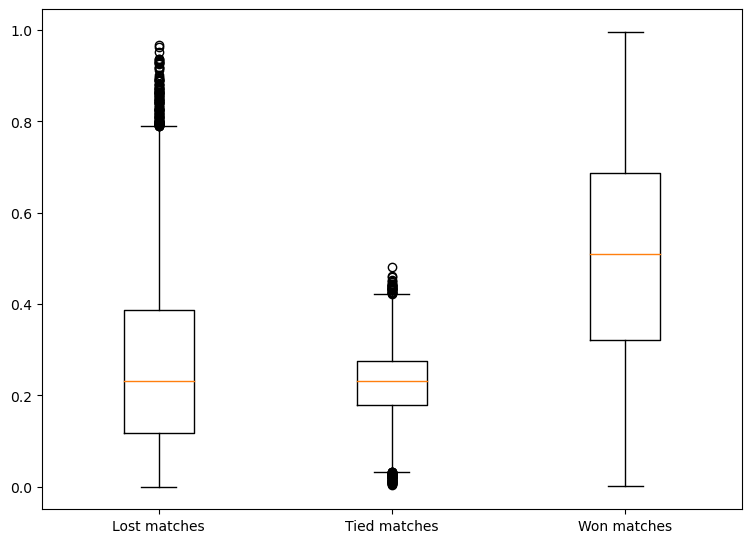

In [32]:
to_plot = [data_loose, draw, data_win]

fig = plt.figure(figsize = (7, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(['Lost matches', 'Tied matches', 'Won matches'])
bp = ax.boxplot(to_plot)

As it can be seen, the model tends to give higher probabilities to teams playing at home (listed first). The problem is that the World Cup is played on the neutral ground. As a result, we can conclude that for presented prediction purpose the model is biased. 

Main source of the problem is the fact, that greater share of games is played on non-neutral ground. This means that the bias comes from the training dataset. Including 'neutral' variable into the model does not allow it to fully control the variability of home team advantage.

From our perspective, probability to win as a first listed team and probability to win as a second listed team should be the same.

### Trying to reduce home-team advantage, by implementing away team bonus

In [33]:
X_test_simulate = X_test.copy()

last = float("Inf")
optimal_bonus = 0

while True:
    optimal_bonus += 0.5
    X_test_simulate['away_team_elo_before'] = X_test_simulate['away_team_elo_before'] + 0.5
    predictions_simulate = [[i[2], i[1], i[0]] for i in logreg.predict_proba(X_test_simulate)]
    lost = [i[2] for i in predictions_simulate]
    won = [i[0] for i in predictions_simulate]
    difference = abs(sum(won)/len(won) - sum(lost)/len(lost))
    if difference > last:
        break
    else:
        last = difference
        

optimal_bonus

128.5

In [34]:
X_test_equal = X_test.copy()
X_test_equal['away_team_elo_before'] = X_test_equal['away_team_elo_before'] + optimal_bonus

predictions_equal = [[i[2], i[1], i[0]] for i in logreg.predict_proba(X_test_equal)]

draw = [i[1] for i in predictions_equal]
data_loose = [i[2] for i in predictions_equal]
data_win = [i[0] for i in predictions_equal]

In [35]:
print(f"Mean probability of draw: {sum(draw)/len(draw)}")
print(f"Mean probability of win for team A: {sum(data_win)/len(data_win)}")
print(f"Mean probability of win for team B: {sum(data_loose)/len(data_loose)}")

Mean probability of draw: 0.2299103022278089
Mean probability of win for team A: 0.38446121021816404
Mean probability of win for team B: 0.385628487554026


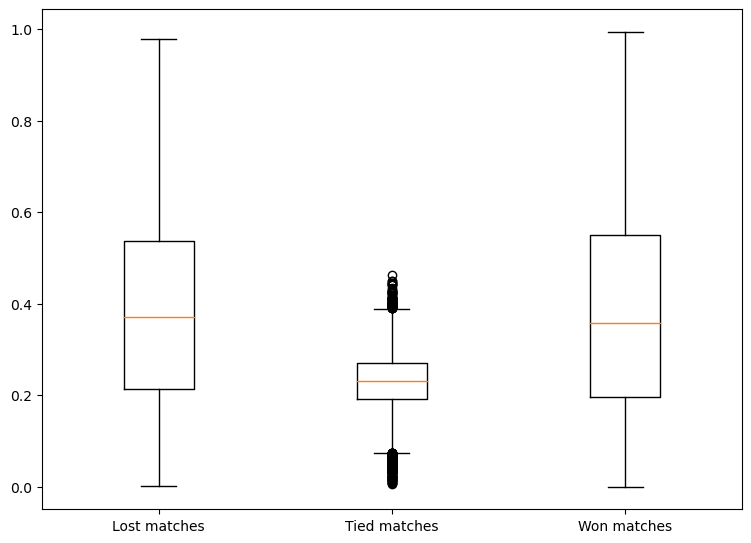

In [36]:
to_plot = [data_loose, draw, data_win]

fig = plt.figure(figsize = (7, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(['Lost matches', 'Tied matches', 'Won matches'])
bp = ax.boxplot(to_plot)

### Define a function for unbiased probability (the same no matter if a team is listed first or second)

In [37]:
def evaluate_match(teams_list, elo_dictionary = None, model = None, should_print = True, draw_possible = True):
    
    if elo_dictionary:
        score_A, score_B = elo_dictionary[teams_list[0]], elo_dictionary[teams_list[1]]
        
    else:
        score_A, score_B = teams_list[0], teams_list[1]
    
    m = score_A * score_B
    
    evaluation_A = logreg.predict_proba(np.array([score_A, score_B + optimal_bonus, m]).reshape(1, -1))[0].tolist()
    evaluation_B = logreg.predict_proba(np.array([score_B, score_A + optimal_bonus, m]).reshape(1, -1))[0].tolist()
    
    evaluation_A_mean =  (evaluation_A[2] + evaluation_B[0])/2
    evaluation_B_mean =  (evaluation_A[0] + evaluation_B[2])/2
    evaluation_draw = 1 - evaluation_A_mean - evaluation_B_mean
    
    result = {"A": evaluation_A_mean, "Draw": evaluation_draw, "B": evaluation_B_mean}
    result_sorted = sorted(result, reverse = True, key = lambda x: result[x])
    
    if evaluation_A_mean > evaluation_B_mean:
        string = teams_list[0]
        r = 2.0

    else:
        string = teams_list[1]
        r = 0.0
    
    if draw_possible:
        
        if evaluation_draw == max([v for i, v in result.items()]):
            string = "draw"
            r = 1.0

        elif result[result_sorted[0]] - (result[result_sorted[1]] + result[result_sorted[2]])/2 <= 0.05:
            string = "draw"
            r = 1.0
        
    if should_print:
        print(teams_list[0], ':', score_A)
        print(teams_list[1], ':', score_B)
        print(result)
        print(f'Predicted: {string}')
        print('\n')
    
    return r
    

### Test function

In [38]:
evaluate_match(['Poland', 'Chile'], score_dict, logreg, should_print = True)

Poland : 1835.8734289048857
Chile : 1733.1801698711154
{'A': 0.46226801986023064, 'Draw': 0.30598407411261025, 'B': 0.23174790602715906}
Predicted: Poland




2.0

In [39]:
evaluate_match(['Chile', 'Poland'], score_dict, logreg, should_print = True)

Chile : 1733.1801698711154
Poland : 1835.8734289048857
{'A': 0.23174790602715906, 'Draw': 0.30598407411261036, 'B': 0.46226801986023064}
Predicted: Poland




0.0

---

## Test quality of predictions made with evaluate_match function approach

### Create the dataset

In [40]:
games_dataset = final.copy()
neutral_games_dataset = games_dataset[(games_dataset.neutral == True) & (games_dataset.year >= 2000)]
print(f"Dataset contains {len(neutral_games_dataset)} games")

Dataset contains 5191 games


### Add the away team bonus

In [41]:
neutral_games_dataset['away_team_elo_before']  = neutral_games_dataset['away_team_elo_before'] + optimal_bonus

### Pick only needed variables

In [42]:
X_test_neutral = neutral_games_dataset[explanatory_variables]
y_neutral = neutral_games_dataset[target_variable]

### Make predictions

In [43]:
predictions_neutral = [evaluate_match([X_test_neutral['home_team_elo_before'].iloc[i], X_test_neutral['away_team_elo_before'].iloc[i]], model = logreg, should_print = False) for i in range(X_test_neutral.shape[0])]

In [44]:
predictions_neutral = np.array(predictions_neutral)
y_neutral = np.array(y_neutral)

### Add predictions to dataset

In [45]:
neutral_games_dataset['predictions'] = predictions_neutral.tolist()

### Calculate Accuracy

In [46]:
np.sum(predictions_neutral == y_neutral)/len(y_neutral)

0.4947023694856482

### Sample of predictions

In [47]:
neutral_games_dataset[
                            ['home_team', 'away_team', 
                             'home_score', 'away_score', 
                             'home_team_elo_before', 'away_team_elo_before', 
                             'result_recoded', 'predictions']
                        ].tail(10)

,home_team,away_team,home_score,away_score,home_team_elo_before,away_team_elo_before,result_recoded,predictions
44035,Ivory Coast,Guinea,3.0,1.0,1727.423586,1608.621400,2.0,2.0
44038,Madagascar,Benin,3.0,1.0,1428.387854,1642.236908,2.0,0.0
44040,Mauritania,Congo,2.0,0.0,1501.996520,1573.075325,2.0,0.0
44041,Mexico,Colombia,2.0,3.0,1864.869285,2041.091005,0.0,0.0
44043,Paraguay,Morocco,0.0,0.0,1758.144213,1969.286747,1.0,0.0
44044,Peru,El Salvador,4.0,1.0,1859.250416,1713.490440,2.0,2.0
44045,Qatar,Chile,2.0,2.0,1748.266084,1861.233401,1.0,0.0
44046,Saudi Arabia,United States,0.0,0.0,1762.589840,1995.456437,1.0,0.0
44048,United Arab Emirates,Venezuela,0.0,4.0,1666.785572,1797.054977,0.0,0.0
44053,Ukraine,Scotland,0.0,0.0,1801.250490,1897.783249,1.0,0.0


---

## Predict the World Cup games results

### Games list

In [48]:
group_matches_first_round = [
    ['Qatar', 'Ecuador'], ['Senegal', 'Netherlands'],
    ['England', 'Iran'], ['United States', 'Wales'],
    ['Argentina', 'Saudi Arabia'], ['Mexico', 'Poland'],
    ['Denmark', 'Tunisia'], ['France', 'Australia'],
    ['Germany', 'Japan'], ['Spain', 'Costa Rica'],
    ['Morocco', 'Croatia'], ['Belgium', 'Canada'],
    ['Switzerland', 'Cameroon'], ['Brazil', 'Serbia'],
    ['Uruguay', 'South Korea'], ['Portugal', 'Ghana']
]

group_matches_second_round = [
    ['Qatar', 'Senegal'], ['Ecuador', 'Netherlands'],
    ['Wales', 'Iran'], ['United States', 'England'],
    ['Poland', 'Saudi Arabia'], ['Mexico', 'Argentina'],
    ['Denmark', 'France'], ['Tunisia', 'Australia'],
    ['Germany', 'Spain'], ['Japan', 'Costa Rica'],
    ['Morocco', 'Belgium'], ['Croatia', 'Canada'],
    ['Switzerland', 'Brazil'], ['Cameroon', 'Serbia'],
    ['Uruguay', 'Portugal'], ['South Korea', 'Ghana']
]

group_matches_third_round = [
    ['Ecuador', 'Senegal'], ['Qatar', 'Netherlands'],
    ['Wales', 'England'], ['United States', 'Iran'],
    ['Poland', 'Argentina'], ['Mexico', 'Saudi Arabia'],
    ['Denmark', 'Australia'], ['Tunisia', 'France'],
    ['Japan', 'Spain'], ['Germany', 'Costa Rica'],
    ['Croatia', 'Belgium'], ['Morocco', 'Canada'],
    ['Switzerland', 'Serbia'], ['Cameroon', 'Brazil'],
    ['Uruguay', 'Ghana'], ['South Korea', 'Portugal']
]

### First round

In [49]:
for match in group_matches_first_round:
    evaluate_match(match, score_dict, logreg, should_print = True)

Qatar : 1747.8193146913368
Ecuador : 1843.0757408851034
{'A': 0.23766265277199305, 'Draw': 0.3114459500165826, 'B': 0.45089139721142435}
Predicted: Ecuador


Senegal : 1831.6271474615905
Netherlands : 2019.0583572709954
{'A': 0.14855952562144453, 'Draw': 0.32815019974831117, 'B': 0.5232902746302444}
Predicted: Netherlands


England : 1983.0933157249501
Iran : 1888.4521974524941
{'A': 0.41501643861979687, 'Draw': 0.36503263843916506, 'B': 0.21995092294103807}
Predicted: England


United States : 1864.0397311041725
Wales : 1826.735718425402
{'A': 0.37164958294192957, 'Draw': 0.33906481437813113, 'B': 0.28928560267993936}
Predicted: United States


Argentina : 2112.967396630336
Saudi Arabia : 1765.5065459889556
{'A': 0.6829554883706064, 'Draw': 0.2513071571645394, 'B': 0.06573735446485422}
Predicted: Argentina


Mexico : 1856.2342531453658
Poland : 1835.8734289048857
{'A': 0.3521996242070766, 'Draw': 0.34061210324047425, 'B': 0.3071882725524491}
Predicted: draw


Denmark : 1947.0707604645

### Summary of first round predictions

In [50]:
r = [evaluate_match(match, score_dict, logreg, should_print = False) for match in group_matches_first_round]
r_dict = dict(Counter(r))
print(f"Predicted {r_dict[1]} draws")
print(f"Predicted {r_dict[0]} games won by team A")
print(f"Predicted {r_dict[2]} games won by team B")

Predicted 2 draws
Predicted 3 games won by team A
Predicted 11 games won by team B


### Second round

In [51]:
for match in group_matches_second_round:
    evaluate_match(match, score_dict, logreg, should_print = True)

Qatar : 1747.8193146913368
Senegal : 1831.6271474615905
{'A': 0.2495637268262691, 'Draw': 0.31204780161293955, 'B': 0.4383884715607913}
Predicted: Senegal


Ecuador : 1843.0757408851034
Netherlands : 2019.0583572709954
{'A': 0.15600107946960415, 'Draw': 0.33534378988242297, 'B': 0.5086551306479729}
Predicted: Netherlands


Wales : 1826.735718425402
Iran : 1888.4521974524941
{'A': 0.2623870529734808, 'Draw': 0.34047208658495287, 'B': 0.39714086044156627}
Predicted: Iran


United States : 1864.0397311041725
England : 1983.0933157249501
{'A': 0.20068794462767753, 'Draw': 0.3530886481805434, 'B': 0.4462234071917791}
Predicted: England


Poland : 1835.8734289048857
Saudi Arabia : 1765.5065459889556
{'A': 0.4199261956619852, 'Draw': 0.31838781344461514, 'B': 0.26168599089339967}
Predicted: Poland


Mexico : 1856.2342531453658
Argentina : 2112.967396630336
{'A': 0.10308721820937826, 'Draw': 0.318369276438774, 'B': 0.5785435053518477}
Predicted: Argentina


Denmark : 1947.070760464522
France :

### Summary of second round predictions

In [52]:
r = [evaluate_match(match, score_dict, logreg, should_print = False) for match in group_matches_second_round]
r_dict = dict(Counter(r))
print(f"Predicted {r_dict[1]} draws")
print(f"Predicted {r_dict[0]} games won by team A")
print(f"Predicted {r_dict[2]} games won by team B")

Predicted 3 draws
Predicted 9 games won by team A
Predicted 4 games won by team B


### Third round

In [53]:
for match in group_matches_third_round:
    evaluate_match(match, score_dict, logreg, should_print = True)

Ecuador : 1843.0757408851034
Senegal : 1831.6271474615905
{'A': 0.343850809260526, 'Draw': 0.3377472791020522, 'B': 0.31840191163742176}
Predicted: draw


Qatar : 1747.8193146913368
Netherlands : 2019.0583572709954
{'A': 0.10090923459649817, 'Draw': 0.2725032325136084, 'B': 0.6265875328898934}
Predicted: Netherlands


Wales : 1826.735718425402
England : 1983.0933157249501
{'A': 0.1729380231485506, 'Draw': 0.3327269464710351, 'B': 0.4943350303804142}
Predicted: England


United States : 1864.0397311041725
Iran : 1888.4521974524941
{'A': 0.2975293049729073, 'Draw': 0.35196100566316146, 'B': 0.35050968936393123}
Predicted: draw


Poland : 1835.8734289048857
Argentina : 2112.967396630336
{'A': 0.09362953019637187, 'Draw': 0.30318841860686585, 'B': 0.6031820511967623}
Predicted: Argentina


Mexico : 1856.2342531453658
Saudi Arabia : 1765.5065459889556
{'A': 0.4419986599695674, 'Draw': 0.3177929310999106, 'B': 0.24020840893052206}
Predicted: Mexico


Denmark : 1947.070760464522
Australia : 1

### Summary of third round predictions

In [54]:
r = [evaluate_match(match, score_dict, logreg, should_print = False) for match in group_matches_third_round]
r_dict = dict(Counter(r))
print(f"Predicted {r_dict[1]} draws")
print(f"Predicted {r_dict[0]} games won by team A")
print(f"Predicted {r_dict[2]} games won by team B")


Predicted 3 draws
Predicted 8 games won by team A
Predicted 5 games won by team B
